# Country results for Heatwaves total exposures

Calculate N exposures for each country


In [2]:
%matplotlib inline

In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl

from scipy import stats
from numba import jit
from tqdm import tnrange, tqdm_notebook, tqdm

import population_tools

from config import DATA_SRC, POP_DATA_SRC, WEATHER_SRC

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

In [4]:
MAX_YEAR = 2018
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

RESULTS_FOLDER = Path('./results/lancet2019/1.2 heatwaves')

POPULATION_FILE = POP_DATA_SRC / 'population_count_2000-2020_30min_era_compat.nc'
DEMOGRAPHICS_FILE = POP_DATA_SRC / 'demographic_pct_2010_30min_era_compat.nc'

# NOTE that we are now using 0.5 degree data (older versions used 0.75)
MIN_TEMPERATURES_FOLDER = WEATHER_SRC / 'era_interim_0.5deg' / 'summer_min_temperature'
CLIMATOLOGY_DAILY_FILE = WEATHER_SRC / 'era_interim_0.5deg' / 'climatology_daily_tmin_quantiles.nc'

# WISHLIST - instead of re-calculating the whole thing each year, would like to just add the newest year.
# For this would need to stablise the method though - discuss with Nick et al.
# I'm not sure it's possible to 'fully' automate since e.g. the demographic data might need to change, GWPv4 is only until 2020
# TODO: indicator -> results for year or result year -> indicator?
INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'heatwaves'/ 'results_2019'


# TODO - should not need these anymore with the new gridded demographics
UN_DEMOGRAPHICS_FILE  = POP_DATA_SRC / 'UN' / 'WPP2017_PopulationByAgeSex_Medium.csv'
COUNTRY_SHAPEFILE = DATA_SRC / 'GIS' / 'world'/ 'ne_50m_admin_0_countries' / 'ne_50m_admin_0_countries.shp'


COUNTRY_ID_LOOKUP = DATA_SRC/ 'lancet/population/gpwv4/gpw_v4_national_identifier_lookup.txt'
COUNTRY_RASTER_FILES = DATA_SRC/ 'lancet/population/country_codes_30min_era_compat.nc'

# LIMIT to the following countries for now
# TODO move to 3-letter codes 
# SELECTED_COUNTRIES = ['AU', 'BR', 'CA', 'CN', 'DE', 'ES', 'EU', 'FR', 'GB','IN', 'SE', 'US', 'NL', 'PL']
# SELECTED_COUNTRIES.sort()

## Load country data

In [5]:
COUNTRIES = gpd.read_file(str(COUNTRY_SHAPEFILE))
COUNTRIES_RASTER = xr.open_dataset(COUNTRY_RASTER_FILES).load()

COUNTRIES_LOOKUP = pd.read_csv(COUNTRY_ID_LOOKUP,sep='\t')

In [6]:
COUNTRIES_LOOKUP.head()

GRIDCODE ISOCODE  UNSDCODE           NAME0  CIESINCODE  \
0         4     AFG         4     Afghanistan           4   
1         8     ALB         8         Albania           8   
2        12     DZA        12         Algeria          12   
3        16     ASM        16  American Samoa          16   
4        20     AND        20         Andorra          20   

                         DATATYPE  DATACODE  DATAYEAR  DATALEVEL  GRSTART  \
0  Population estimate/projection         6      2011          2     1998   
1                    Final census         1      2011          3     2001   
2                    Final census         1      2008          2     1998   
3                    Final census         1      2010          3     2000   
4             Population register         5      2010          1     2000   

   GREND  GRLEVEL  LASTCENSUS    MEANUNITKM  
0   2011        1        1979   4507.466751  
1   2011        3        2011    115.949835  
2   2008        2        2008  50884.794880  
3   2010        3        2010      7.612468  
4   2010        1        2011     79.902822

## Load age percentage rasters

In [7]:
demographics = xr.open_dataarray(DEMOGRAPHICS_FILE)
fraction_over_65 = demographics.sel(age_band_lower_bound=65, drop=True).load()
population = xr.open_dataarray(POPULATION_FILE)
population_over_65 = population * fraction_over_65

## Heatwave change

### Load data


In [8]:
heatwaves_counts = xr.open_dataarray(INTERMEDIATE_RESULTS_FOLDER / 'heatwaves_counts_all_years.nc')

In [9]:
heatwaves_exposures_total = heatwaves_counts * population_over_65

In [7]:
# heatwaves_lengths_delta = xr.open_dataarray(INTERMEDIATE_RESULTS_FOLDER /'heatwaves_lengths_delta.nc')
heatwaves_counts_delta = xr.open_dataarray(INTERMEDIATE_RESULTS_FOLDER /'heatwaves_counts_delta.nc')
heatwaves_exposures_delta = xr.open_dataarray(INTERMEDIATE_RESULTS_FOLDER / f'heatwave_exposure_events_change_2000-{MAX_YEAR}.nc')

# N Exposures by country


For Heatwaves, want the same plots as were in the original paper

- the heatwave exposure total number change (not normalised)
- the heatwave length change


In [32]:
COUNTRIES_LOOKUP

GRIDCODE ISOCODE  UNSDCODE                                         NAME0  \
0           4     AFG         4                                   Afghanistan   
1           8     ALB         8                                       Albania   
2          12     DZA        12                                       Algeria   
3          16     ASM        16                                American Samoa   
4          20     AND        20                                       Andorra   
..        ...     ...       ...                                           ...   
243       905     IOT         0                British Indian Ocean Territory   
244       906     SGS         0  South Georgia and the South Sandwich Islands   
245       907     SPR         0                               Spratly Islands   
246       908     UMI         0          United States Minor Outlying Islands   
247       999     KOS         0                                        Kosovo   

     CIESINCODE                        DATATYPE  DATACODE  DATAYEAR  \
0             4  Population estimate/projection         6      2011   
1             8                    Final census         1      2011   
2            12                    Final census         1      2008   
3            16                    Final census         1      2010   
4            20             Population register         5      2010   
..          ...                             ...       ...       ...   
243         905                  Not applicable         0         0   
244         906                  Not applicable         0         0   
245         907                  Not applicable         0         0   
246         908                  Not applicable         0         0   
247         999                    Final census         1      2011   

     DATALEVEL  GRSTART  GREND  GRLEVEL  LASTCENSUS    MEANUNITKM  
0            2     1998   2011        1        1979   4507.466751  
1            3     2001   2011        3        2011    115.949835  
2            2     1998   2008        2        2008  50884.794880  
3            3     2000   2010        3        2010      7.612468  
4            1     2000   2010        1        2011     79.902822  
..         ...      ...    ...      ...         ...           ...  
243          0        0      0        0           0     64.373238  
244          0        0      0        0           0   1605.277710  
245          0        0      0        0           0      1.886426  
246          0        0      0        0           0     41.589767  
247          1     2011   2012        1        2011    405.642441  

[248 rows x 14 columns]

In [11]:
exposure_totals = []
    
for _, row in tqdm_notebook(COUNTRIES_LOOKUP.iterrows(), total=len(COUNTRIES_LOOKUP)):
    grid_code = row.GRIDCODE
    country_mask = COUNTRIES_RASTER.country_codes == grid_code

    country_exposures_ts = (heatwaves_exposures_total * country_mask).sum(dim=['latitude', 'longitude'])

    exposure_results.append(country_exposures_ts.to_dataframe(row.ISOCODE))

exposure_totals = pd.concat(exposure_results, axis=1)

In [15]:
# Save excel 
with pd.ExcelWriter(RESULTS_FOLDER / f'heatwaves_n_exposure_total_2000-{MAX_YEAR}.xlsx', mode='w') as writer:
    exposure_totals.to_excel(writer, sheet_name='countries_heatwave_exposures_tot')

In [22]:
exposure_change = pd.read_excel(RESULTS_FOLDER / f'heatwaves_n_exposure_change_2000-{MAX_YEAR}.xlsx',
                                  sheet_name='countries_heatwave_exposures').set_index('year')

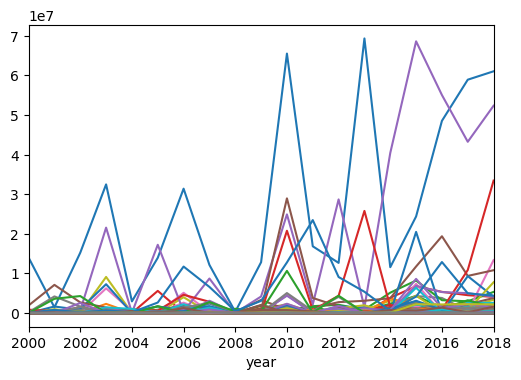

In [27]:
exposure_results.plot(legend=False)

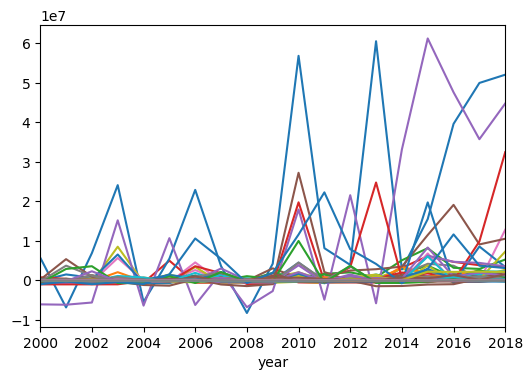

In [28]:
exposure_change.plot(legend=False)

In [37]:
exposure_change['CHN'] / exposure_results['CHN']

year
2000     0.411306
2001    -4.820195
2002     0.453547
2003     0.742514
2004    -1.864460
2005     0.394093
2006     0.729719
2007     0.297588
2008   -26.947920
2009     0.328572
2010     0.867923
2011     0.483888
2012     0.309676
2013     0.873387
2014     0.237734
2015     0.636460
2016     0.816693
2017     0.848481
2018     0.853214
Name: CHN, dtype: float64

# Save the gridded (country detailed) data as a text file for the visualisation people

NOTE: since it's gridded, don't actully need to add country masks (maybe they want them later i don't know...)

In [22]:
EXPOSURES_EXCEL_FOLDER = RESULTS_FOLDER / 'exposure_maps_as_tables'
EXPOSURES_EXCEL_FOLDER.mkdir(exist_ok=True)

In [36]:
for year in range(2000, MAX_YEAR+1):
    heatwave_exposures_long = heatwaves_pop_events.sel(year=year).to_dataframe('heatwave_exposure_change').dropna().reset_index()
    heatwave_exposures_long.to_csv(EXPOSURES_EXCEL_FOLDER/ f'{year}_heatwave_exposure_change.csv', index=False)